In [1]:
import os
from shapely.geometry import Point, Polygon
from shapely.vectorized import contains
from tifffile import imread
import random
import numpy as np
import pandas as pd
from concurrent.futures import ProcessPoolExecutor, as_completed
from functools import partial
import multiprocessing as mp
from scipy.ndimage import gaussian_filter
from skimage.measure import find_contours
from scipy.stats import pearsonr
from scipy import stats
from PIL import Image, ImageDraw
from skimage.filters import threshold_otsu, threshold_triangle, threshold_local
import matplotlib.pyplot as plt
import seaborn as sns
from statannotations.Annotator import Annotator

sns.set(color_codes=True, style="white")

# Setup

In [2]:
nm_per_pxl = 131.5

folder = "/Volumes/guttman/Guoming_Gao-Resnick/Data_BIF/2025-06-28-Malat1_mouse_postSTORM/Malat1-SC35-zstack"
os.chdir(folder)

label1 = "control ASO"
label2 = "Malat1 KD"

prefix1 = "M1SC35-R7-WT_undiff-MIP_montage-"
prefix2 = "M1SC35-R7-Malat1KD_undiff-MIP_montage-"

postfix1 = "DAPI.tif"
postfix2 = "SC35_488.tif"
postfix3 = "Malat1_647.tif"

img1_ch1 = imread(prefix1 + postfix1)
img1_ch2 = imread(prefix1 + postfix2)
img1_ch3 = imread(prefix1 + postfix3)
img2_ch1 = imread(prefix2 + postfix1)
img2_ch2 = imread(prefix2 + postfix2)
img2_ch3 = imread(prefix2 + postfix3)

cell_roi_files_1 = [
    f for f in os.listdir(".") if f.startswith("M1SC35-R7-WT_undiff-cell")
]
cell_roi_files_2 = [
    f for f in os.listdir(".") if f.startswith("M1SC35-R7-Malat1KD_undiff-cell")
]

In [3]:
def create_cell_polygon(cell_roi_file, nm_per_pxl):
    """
    Create a Shapely Polygon from ROI coordinate file.

    Args:
        cell_roi_file: Path to tab-separated file with polygon coordinates (in micrometers)
        nm_per_pxl: Conversion factor from nanometers to pixels

    Returns:
        shapely.geometry.Polygon: Cell boundary polygon in pixel coordinates
    """
    # Load coordinates (assumed to be in micrometers)
    cell_outline_coordinates = pd.read_csv(cell_roi_file, sep="\t", header=None)

    # Convert from micrometers to pixels: um * 1000 / nm_per_pxl
    coords_roi = [
        tuple(row * 1000 / nm_per_pxl) for _, row in cell_outline_coordinates.iterrows()
    ]

    cell_polygon = Polygon(coords_roi)
    return cell_polygon


def load_cell_rois(cell_roi_files):
    # Load manual ROI coordinates and extract cell IDs
    cell_polygons = []
    cell_ids = []
    for roi_file in cell_roi_files:
        try:
            filename = os.path.basename(roi_file)
            cell_id = filename.split("cell")[1][:-4]
            cell_ids.append(cell_id)
            cell_polygon = create_cell_polygon(roi_file, nm_per_pxl)
            cell_polygons.append(cell_polygon)
        except Exception as e:
            print(f"Error loading {roi_file}: {e}")
            continue

    return cell_ids, cell_polygons

cell_ids_1, cell_polygons_condition1 = load_cell_rois(cell_roi_files_1)
cell_ids_2, cell_polygons_condition2 = load_cell_rois(cell_roi_files_2)

# Cell Segmentation

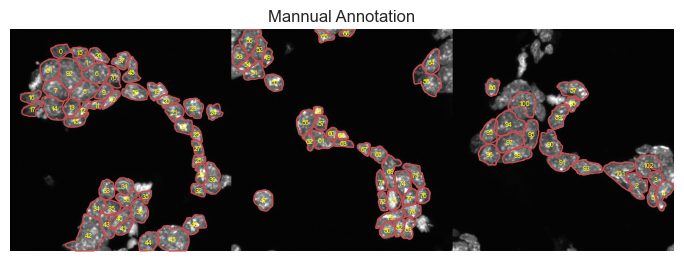

In [32]:
img_DAPI = img1_ch1
fname_save = prefix1 + "cell_validation.png"
cell_polygons = cell_polygons_condition1

# Create final visualization with better contrast
plt.figure(figsize=(7, 3))

# Adaptive thresholding result with enhanced contrast
vmin, vmax = np.percentile(
    img_DAPI, [1, 99.9]
)  # Use 1st and 99th percentiles for better contrast
plt.imshow(img_DAPI, cmap="gray", vmin=vmin, vmax=vmax)
plt.title(f"Mannual Annotation")

# Plot cell boundaries in blue
for idx, cell_polygon in enumerate(cell_polygons):
    x, y = cell_polygon.exterior.xy
    plt.plot(x, y, "r-", linewidth=1)
    centroid = cell_polygon.centroid
    plt.text(
        centroid.x,
        centroid.y,
        str(idx),
        color="yellow",
        fontsize=5,
        ha="center",
        va="center",
    )

plt.axis("off")
plt.tight_layout()
plt.savefig(
    fname_save,
    format="png",
    dpi=600,
    bbox_inches=0,
)

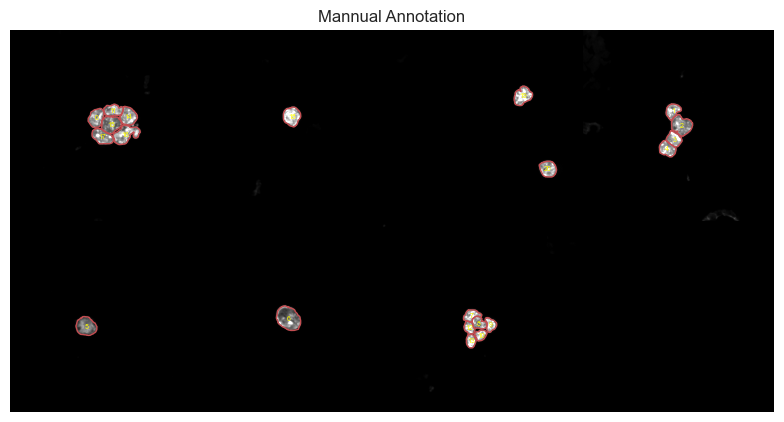

In [5]:
img_DAPI = img2_ch1
fname_save = prefix2 + "cell_validation.png"
cell_polygons = cell_polygons_condition2

# Create final visualization with better contrast
plt.figure(figsize=(8, 5))

# Adaptive thresholding result with enhanced contrast
vmin, vmax = np.percentile(
    img_DAPI, [90, 99.9]
)  # Use 1st and 99th percentiles for better contrast
plt.imshow(img_DAPI, cmap="gray", vmin=vmin, vmax=vmax)
plt.title(f"Mannual Annotation")

# Plot cell boundaries in blue
for idx, cell_polygon in enumerate(cell_polygons):
    x, y = cell_polygon.exterior.xy
    plt.plot(x, y, "r-", linewidth=1)
    centroid = cell_polygon.centroid
    plt.text(
        centroid.x,
        centroid.y,
        str(idx),
        color="yellow",
        fontsize=5,
        ha="center",
        va="center",
    )

plt.axis("off")
plt.tight_layout()
plt.savefig(
    fname_save,
    format="png",
    dpi=600,
    bbox_inches=0,
)

# Calculate Stats

## Non-puncta stats

In [6]:
import numpy as np
import pandas as pd
import cv2
from shapely.geometry import Polygon
from scipy import stats
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt


def polygon_to_mask(polygon, width, height):
    """Convert a shapely Polygon to a binary mask."""
    img = Image.new("L", (width, height), 0)
    coords = list(polygon.exterior.coords)
    ImageDraw.Draw(img).polygon(coords, outline=1, fill=1)
    mask = np.array(img, dtype=bool)
    return mask


def calculate_equivalent_radius(polygon):
    """Calculate equivalent radius from polygon area."""
    area = polygon.area
    # Equivalent radius: radius of circle with same area
    return np.sqrt(area / np.pi) * nm_per_pxl / 1e3  # unit: micron


def extract_polygon_metrics(image, polygons, label_name):
    """
    Extract comprehensive metrics for each polygon.

    Args:
        image: 2D numpy array (grayscale image)
        polygons: list of shapely Polygon objects
        label_name: string identifier for the image/condition

    Returns:
        pandas DataFrame with all requested metrics
    """

    # Initialize lists to store metrics
    labels = []
    polygon_indices = []
    equivalent_radii = []
    max_intensities = []
    mode_intensities = []
    mean_intensities = []
    std_intensities = []
    dispersion_scores = []

    # Get image dimensions
    height, width = image.shape[:2]

    for i, polygon in enumerate(polygons):
        try:
            # Basic polygon info
            labels.append(label_name)
            polygon_indices.append(i)

            # Calculate equivalent radius
            equiv_radius = calculate_equivalent_radius(polygon)
            equivalent_radii.append(equiv_radius)

            # Create mask and extract pixels
            mask = polygon_to_mask(polygon, width, height)
            masked_pixels = image[mask]

            if len(masked_pixels) > 0:
                # Calculate intensity metrics
                max_intensity = np.max(masked_pixels)
                mean_intensity = np.mean(masked_pixels)
                std_intensity = np.std(masked_pixels)

                # Calculate mode intensity
                mode_result = stats.mode(masked_pixels, keepdims=True)
                mode_intensity = mode_result.mode[0]

                # Calculate 99th percentile
                percentile_99 = np.percentile(masked_pixels, 99)

                # Calculate dispersion score (99th percentile / mode)
                if mode_intensity > 0:
                    dispersion_score = percentile_99 / mode_intensity
                else:
                    dispersion_score = np.inf  # or np.nan

                # Store results
                max_intensities.append(max_intensity)
                mode_intensities.append(mode_intensity)
                mean_intensities.append(mean_intensity)
                std_intensities.append(std_intensity)
                dispersion_scores.append(dispersion_score)

            else:
                # Handle empty polygons
                max_intensities.append(np.nan)
                mode_intensities.append(np.nan)
                mean_intensities.append(np.nan)
                std_intensities.append(np.nan)
                dispersion_scores.append(np.nan)

        except Exception as e:
            print(f"Error processing polygon {i}: {e}")
            # Add NaN values for failed polygons
            labels.append(label_name)
            polygon_indices.append(i)
            equivalent_radii.append(np.nan)
            max_intensities.append(np.nan)
            mode_intensities.append(np.nan)
            mean_intensities.append(np.nan)
            std_intensities.append(np.nan)
            dispersion_scores.append(np.nan)

    # Create DataFrame
    df = pd.DataFrame(
        {
            "Label": labels,
            "Cell_Index": polygon_indices,
            "Cell_Radius_um": equivalent_radii,
            "Max_Intensity": max_intensities,
            "Mode_Intensity": mode_intensities,
            "Mean_Intensity": mean_intensities,
            "STD_Intensity": std_intensities,
            "Dispersion_Score": dispersion_scores,
        }
    )

    return df


def process_multiple_images(images_dict, cell_polygons_dict):
    """
    Process multiple images and combine results into a single DataFrame.
    FIXED: Now uses condition-specific polygons for each image.

    Args:
        images_dict: dictionary with {label: image_array} pairs
        cell_polygons_dict: dictionary with {label: polygons_list} pairs

    Returns:
        Combined pandas DataFrame with all images and metrics
    """

    all_dataframes = []

    for label, image in images_dict.items():
        # Get the corresponding polygons for this condition
        polygons = cell_polygons_dict[label]
        df = extract_polygon_metrics(image, polygons, label)
        all_dataframes.append(df)

    # Combine all DataFrames
    combined_df = pd.concat(all_dataframes, ignore_index=True)

    return combined_df


def extract_polygon_PCC(image_ch1, image_ch2, polygons, label_name):
    """
    Extract Pearson correlation coefficient between two channels for each polygon.

    Args:
        image_ch1: 2D numpy array (first channel)
        image_ch2: 2D numpy array (second channel)
        polygons: list of shapely Polygon objects
        label_name: string identifier for the condition

    Returns:
        pandas DataFrame with PCC metrics
    """

    # Initialize lists to store metrics
    labels = []
    polygon_indices = []
    equivalent_radii = []
    pcc_values = []
    pcc_pvalues = []
    pixel_counts = []
    ch1_mean_intensities = []
    ch2_mean_intensities = []

    # Get image dimensions
    height, width = image_ch1.shape[:2]

    for i, polygon in enumerate(polygons):
        try:
            # Basic polygon info
            labels.append(label_name)
            polygon_indices.append(i)

            # Calculate equivalent radius
            equiv_radius = calculate_equivalent_radius(polygon)
            equivalent_radii.append(equiv_radius)

            # Create mask and extract pixels from both channels
            mask = polygon_to_mask(polygon, width, height)
            ch1_pixels = image_ch1[mask]
            ch2_pixels = image_ch2[mask]

            if (
                len(ch1_pixels) > 1 and len(ch2_pixels) > 1
            ):  # Need at least 2 points for correlation
                # Calculate Pearson correlation coefficient
                pcc, p_value = pearsonr(ch1_pixels, ch2_pixels)

                # Calculate additional metrics
                ch1_mean = np.mean(ch1_pixels)
                ch2_mean = np.mean(ch2_pixels)
                pixel_count = len(ch1_pixels)

                # Store results
                pcc_values.append(pcc)
                pcc_pvalues.append(p_value)
                pixel_counts.append(pixel_count)
                ch1_mean_intensities.append(ch1_mean)
                ch2_mean_intensities.append(ch2_mean)

            else:
                # Handle empty or single-pixel polygons
                pcc_values.append(np.nan)
                pcc_pvalues.append(np.nan)
                pixel_counts.append(len(ch1_pixels))
                ch1_mean_intensities.append(np.nan)
                ch2_mean_intensities.append(np.nan)

        except Exception as e:
            print(f"Error processing polygon {i}: {e}")
            # Add NaN values for failed polygons
            labels.append(label_name)
            polygon_indices.append(i)
            equivalent_radii.append(np.nan)
            pcc_values.append(np.nan)
            pcc_pvalues.append(np.nan)
            pixel_counts.append(0)
            ch1_mean_intensities.append(np.nan)
            ch2_mean_intensities.append(np.nan)

    # Create DataFrame
    df = pd.DataFrame(
        {
            "Label": labels,
            "Cell_Index": polygon_indices,
            "Cell_Radius_um": equivalent_radii,
            "PCC": pcc_values,
            "PCC_pvalue": pcc_pvalues,
            "Pixel_Count": pixel_counts,
            "Ch1_Mean_Intensity": ch1_mean_intensities,
            "Ch2_Mean_Intensity": ch2_mean_intensities,
        }
    )

    return df


def process_multiple_images_PCC(images_dict, cell_polygons_dict):
    """
    Process multiple image pairs and combine PCC results into a single DataFrame.

    Args:
        images_dict: dictionary with {label: (image_ch1, image_ch2)} pairs
        cell_polygons_dict: dictionary with {label: polygons_list} pairs

    Returns:
        Combined pandas DataFrame with all conditions and PCC metrics
    """

    all_dataframes = []

    for label, (image_ch1, image_ch2) in images_dict.items():
        polygons = cell_polygons_dict[label]
        df = extract_polygon_PCC(image_ch1, image_ch2, polygons, label)
        all_dataframes.append(df)

    # Combine all DataFrames
    combined_df = pd.concat(all_dataframes, ignore_index=True)

    return combined_df

In [7]:
cell_polygons_dict = {label1: cell_polygons_condition1, label2: cell_polygons_condition2}
images_dict = {label1: img1_ch2, label2: img2_ch2}
df_SC35_perCell_stats = process_multiple_images(images_dict, cell_polygons_dict)
df_SC35_perCell_stats.to_csv("Malat1_WT_vs_KD-perCell_stats-SC35.csv", index=False)
images_dict = {label1: img1_ch3, label2: img2_ch3}
df_Malat1_perCell_stats = process_multiple_images(images_dict, cell_polygons_dict)
df_Malat1_perCell_stats.to_csv("Malat1_WT_vs_KD-perCell_stats-Malat1.csv", index=False)
images_dict = {label1: (img1_ch2, img1_ch3), label2: (img2_ch2, img2_ch3)}
df_PCC_perCell_stats = process_multiple_images_PCC(images_dict, cell_polygons_dict)
df_PCC_perCell_stats.to_csv("Malat1_WT_vs_KD-perCell_stats-PCC.csv", index=False)

## Puncta segmentation, adaptive threshold

In [8]:
def filter_outer_contours_only(contours, area_threshold=5):
    """
    Filter contours to keep only outer boundaries, removing holes/inner contours.

    Args:
        contours: List of contours from find_contours
        area_threshold: Minimum area to keep objects

    Returns:
        List of shapely polygons representing only outer boundaries
    """
    # Convert all contours to shapely polygons first
    candidate_polygons = []
    for contour in contours:
        if len(contour) >= 3:  # Need at least 3 points for a polygon
            try:
                polygon = Polygon(contour[:, [1, 0]])  # Switch to x,y format
                if polygon.is_valid and polygon.area > area_threshold:
                    candidate_polygons.append(polygon)
            except:
                continue  # Skip invalid polygons

    if not candidate_polygons:
        return []

    # Identify and remove holes (inner contours)
    outer_polygons = []
    for i, polygon in enumerate(candidate_polygons):
        is_hole = False

        # Check if this polygon is contained within any other polygon
        for j, other_polygon in enumerate(candidate_polygons):
            if i != j:  # Don't compare with itself
                try:
                    # Check if current polygon is completely contained within other polygon
                    # and has smaller area (indicating it's a hole)
                    if (
                        other_polygon.contains(polygon)
                        and polygon.area < other_polygon.area
                    ):
                        is_hole = True
                        break
                except:
                    continue  # Skip if geometric operations fail

        # Keep only non-hole polygons
        if not is_hole:
            outer_polygons.append(polygon)

    return outer_polygons


def remove_overlapping_polygons(polygons):
    """
    Remove smaller polygons that are completely contained within larger ones.
    This handles cases where we might have nested contours at different levels.
    """
    if not polygons:
        return []

    # Sort polygons by area (largest first)
    sorted_polygons = sorted(polygons, key=lambda p: p.area, reverse=True)

    filtered_polygons = []

    for polygon in sorted_polygons:
        is_contained = False

        # Check if this polygon is contained in any already accepted polygon
        for accepted_polygon in filtered_polygons:
            try:
                if accepted_polygon.contains(polygon):
                    is_contained = True
                    break
            except:
                continue

        # Only add if not contained in any larger polygon
        if not is_contained:
            filtered_polygons.append(polygon)

    return filtered_polygons


def polygon_to_mask(polygon, width, height):
    """Convert a shapely Polygon to a binary mask."""
    img = Image.new("L", (width, height), 0)
    coords = list(polygon.exterior.coords)
    ImageDraw.Draw(img).polygon(coords, outline=1, fill=1)
    mask = np.array(img, dtype=bool)
    return mask


def adaptive_threshold_within_cells_min20_std(
    img_signal, cell_polygons, std_multiplier=3.0, area_threshold=5, sigma=1
):
    """
    Perform adaptive thresholding within each cell to detect puncta.

    Args:
        img_signal: Original image
        cell_polygons: List of shapely polygons representing cell boundaries
        std_multiplier: Multiplier for standard deviation in threshold calculation
        area_threshold: Minimum area for puncta
        sigma: Gaussian smoothing parameter

    Returns:
        all_puncta_polygons: List of all puncta polygons
        cell_stats: Dictionary with statistics for each cell
    """

    # Apply Gaussian smoothing
    img_smoothed = gaussian_filter(img_signal, sigma=sigma, mode="reflect")

    # Get image dimensions
    height, width = img_smoothed.shape

    all_puncta_polygons = []
    cell_stats = {}

    for cell_idx, cell_polygon in enumerate(cell_polygons):
        try:
            # Create mask for this cell
            cell_mask = polygon_to_mask(cell_polygon, width, height)

            # Extract pixel intensities within the cell
            cell_pixels = img_smoothed[cell_mask]

            if len(cell_pixels) == 0:
                continue

            # Calculate statistics
            cell_mean = np.mean(cell_pixels)
            cell_std = np.std(cell_pixels)
            cell_mode = stats.mode(cell_pixels, keepdims=True).mode[0]
            cell_min20 = np.mean(np.partition(cell_pixels, 19)[:20])

            # Calculate adaptive threshold
            adaptive_threshold = cell_min20 + std_multiplier * cell_std

            # Store cell statistics
            cell_stats[cell_idx] = {
                "mean": cell_mean,
                "std": cell_std,
                "mode": cell_mode,
                "min20": cell_min20,
                "threshold": adaptive_threshold,
                "pixel_count": len(cell_pixels),
            }

            # Create binary mask for this cell with adaptive threshold
            cell_binary = (img_smoothed * cell_mask) > adaptive_threshold

            # Find contours within this cell
            if np.any(cell_binary):
                cell_contours = find_contours(cell_binary, 0.5)

                # Apply the filtering functions to remove holes and overlapping contours
                filtered_puncta = filter_outer_contours_only(
                    cell_contours, area_threshold
                )
                filtered_puncta = remove_overlapping_polygons(filtered_puncta)

                # Only keep puncta that are within the cell
                for puncta_polygon in filtered_puncta:
                    if cell_polygon.contains(puncta_polygon):
                        all_puncta_polygons.append(puncta_polygon)

        except Exception as e:
            continue

    return all_puncta_polygons, cell_stats


def adaptive_threshold_within_cells_mode_std(
    img_signal, cell_polygons, std_multiplier=3.0, area_threshold=5, sigma=1
):
    """
    Perform adaptive thresholding within each cell to detect puncta.

    Args:
        img_signal: Original image
        cell_polygons: List of shapely polygons representing cell boundaries
        std_multiplier: Multiplier for standard deviation in threshold calculation
        area_threshold: Minimum area for puncta
        sigma: Gaussian smoothing parameter

    Returns:
        all_puncta_polygons: List of all puncta polygons
        cell_stats: Dictionary with statistics for each cell
    """

    # Apply Gaussian smoothing
    img_smoothed = gaussian_filter(img_signal, sigma=sigma, mode="reflect")

    # Get image dimensions
    height, width = img_smoothed.shape

    all_puncta_polygons = []
    cell_stats = {}

    for cell_idx, cell_polygon in enumerate(cell_polygons):
        try:
            # Create mask for this cell
            cell_mask = polygon_to_mask(cell_polygon, width, height)

            # Extract pixel intensities within the cell
            cell_pixels = img_smoothed[cell_mask]

            if len(cell_pixels) == 0:
                continue

            # Calculate statistics
            cell_mean = np.mean(cell_pixels)
            cell_std = np.std(cell_pixels)
            cell_mode = stats.mode(cell_pixels, keepdims=True).mode[0]
            cell_min20 = np.mean(np.partition(cell_pixels, 19)[:20])

            # Calculate adaptive threshold
            adaptive_threshold = cell_mode + std_multiplier * cell_std

            # Store cell statistics
            cell_stats[cell_idx] = {
                "mean": cell_mean,
                "std": cell_std,
                "mode": cell_mode,
                "min20": cell_min20,
                "threshold": adaptive_threshold,
                "pixel_count": len(cell_pixels),
            }

            # Create binary mask for this cell with adaptive threshold
            cell_binary = (img_smoothed * cell_mask) > adaptive_threshold

            # Find contours within this cell
            if np.any(cell_binary):
                cell_contours = find_contours(cell_binary, 0.5)

                # Apply the filtering functions to remove holes and overlapping contours
                filtered_puncta = filter_outer_contours_only(
                    cell_contours, area_threshold
                )
                filtered_puncta = remove_overlapping_polygons(filtered_puncta)

                # Only keep puncta that are within the cell
                for puncta_polygon in filtered_puncta:
                    if cell_polygon.contains(puncta_polygon):
                        all_puncta_polygons.append(puncta_polygon)

        except Exception as e:
            continue

    return all_puncta_polygons, cell_stats


def adaptive_threshold_within_cells_otsu(
    img_signal, cell_polygons, area_threshold=5, sigma=1
):
    """
    Perform adaptive thresholding within each cell to detect puncta.

    Args:
        img_signal: Original image
        cell_polygons: List of shapely polygons representing cell boundaries
        area_threshold: Minimum area for puncta
        sigma: Gaussian smoothing parameter

    Returns:
        all_puncta_polygons: List of all puncta polygons
        cell_stats: Dictionary with statistics for each cell
    """

    if sigma == 0:
        img_smoothed = img_signal
    else:
        img_smoothed = gaussian_filter(img_signal, sigma=sigma, mode="reflect")
        height, width = img_smoothed.shape

    all_puncta_polygons = []
    cell_stats = {}

    for cell_idx, cell_polygon in enumerate(cell_polygons):
        try:
            # Create mask for this cell
            cell_mask = polygon_to_mask(cell_polygon, width, height)

            # Extract pixel intensities within the cell
            cell_pixels = img_smoothed[cell_mask]

            if len(cell_pixels) == 0:
                continue

            # Calculate statistics
            cell_mean = np.mean(cell_pixels)
            cell_std = np.std(cell_pixels)
            cell_mode = stats.mode(cell_pixels, keepdims=True).mode[0]
            cell_min20 = np.mean(np.partition(cell_pixels, 19)[:20])

            # Calculate adaptive threshold
            adaptive_threshold = threshold_otsu(cell_pixels)

            # Store cell statistics
            cell_stats[cell_idx] = {
                "mean": cell_mean,
                "std": cell_std,
                "mode": cell_mode,
                "min20": cell_min20,
                "threshold": adaptive_threshold,
                "pixel_count": len(cell_pixels),
            }

            # Create binary mask for this cell with adaptive threshold
            cell_binary = (img_smoothed * cell_mask) > adaptive_threshold

            # Find contours within this cell
            if np.any(cell_binary):
                cell_contours = find_contours(cell_binary, 0.5)

                # Apply the filtering functions to remove holes and overlapping contours
                filtered_puncta = filter_outer_contours_only(
                    cell_contours, area_threshold
                )
                # filtered_puncta = remove_overlapping_polygons(filtered_puncta)

                # Only keep puncta whose centroid is within the cell
                for puncta_polygon in filtered_puncta:
                    if cell_polygon.contains(puncta_polygon.centroid):
                        all_puncta_polygons.append(puncta_polygon)

        except Exception as e:
            continue

    return all_puncta_polygons, cell_stats

### SC35

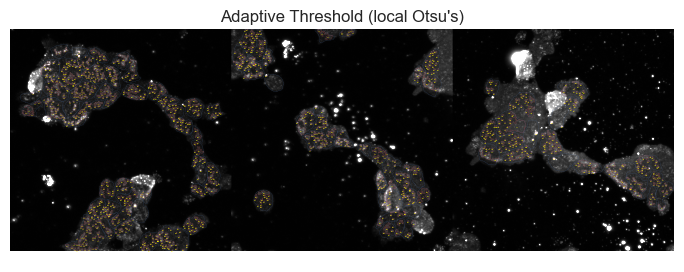

In [11]:
img_signal = img1_ch2
fname_save = prefix1 + "SC35_segmentation.png"
cell_polygons = (
    cell_polygons_condition1  # Cell boundaries to use for puncta detection
)
output_variable_name = (
    "SC35_puncta_condition1"  # Customize this for your naming convention
)

sigma = 1
mode = "reflect"
area_threshold = 10  # Minimum area in pixels to keep objects

# Apply adaptive thresholding to detect puncta within each cell
all_puncta_polygons, cell_statistics = adaptive_threshold_within_cells_otsu(
    img_signal,
    cell_polygons,
    area_threshold=area_threshold,
    sigma=sigma,
)

# Apply Gaussian smoothing for visualization
img_smoothed = gaussian_filter(img_signal, sigma=sigma, mode=mode)

# Create final visualization with better contrast
plt.figure(figsize=(7, 3))

# Adaptive thresholding result with enhanced contrast
vmin, vmax = np.percentile(
    img_signal, [1, 99.5]
)  # Use 1st and 99th percentiles for better contrast
plt.imshow(img_signal, cmap="gray", vmin=vmin, vmax=vmax)
plt.title(f"Adaptive Threshold (local Otsu's)")

# Plot cell boundaries in blue
for idx, cell_polygon in enumerate(cell_polygons):
    x, y = cell_polygon.exterior.xy
    plt.plot(x, y, "b-", linewidth=0.1, alpha=0.8)

# Plot puncta boundaries in red with puncta ID labels
puncta_id = 0
for cell_idx, cell_polygon in enumerate(cell_polygons):
    # Find puncta within this cell
    puncta_in_cell = [
        p for p in all_puncta_polygons if cell_polygon.contains(p.centroid)
    ]

    for puncta_polygon in puncta_in_cell:
        # Plot puncta boundary
        x, y = puncta_polygon.exterior.xy
        plt.plot(x, y, "r-", linewidth=0.1)

        # Add puncta ID label
        centroid = puncta_polygon.centroid
        plt.text(
            centroid.x,
            centroid.y,
            str(puncta_id),
            color="yellow",
            fontsize=1,
            ha="center",
            va="center",
        )
        puncta_id += 1

plt.axis("off")
plt.tight_layout()
plt.savefig(
    fname_save,
    format="png",
    dpi=1200,
    bbox_inches=0,
)

# Store results in the specified variable name
globals()[output_variable_name] = all_puncta_polygons

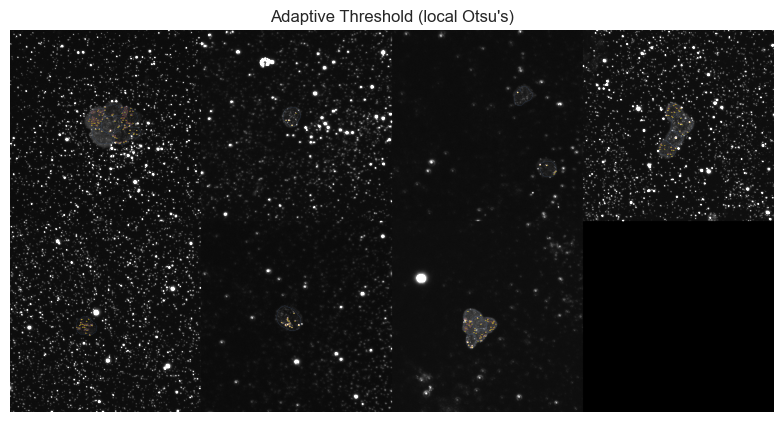

In [13]:
img_signal = img2_ch2
fname_save = prefix2 + "SC35_segmentation.png"
cell_polygons = cell_polygons_condition2  # Cell boundaries to use for puncta detection
output_variable_name = (
    "SC35_puncta_condition2"  # Customize this for your naming convention
)

sigma = 1
mode = "reflect"
area_threshold = 10  # Minimum area in pixels to keep objects

# Apply adaptive thresholding to detect puncta within each cell
all_puncta_polygons, cell_statistics = adaptive_threshold_within_cells_otsu(
    img_signal,
    cell_polygons,
    area_threshold=area_threshold,
    sigma=sigma,
)

# Apply Gaussian smoothing for visualization
img_smoothed = gaussian_filter(img_signal, sigma=sigma, mode=mode)

# Create final visualization with better contrast
plt.figure(figsize=(8, 5))

# Adaptive thresholding result with enhanced contrast
vmin, vmax = np.percentile(
    img_signal, [1, 99.5]
)  # Use 1st and 99th percentiles for better contrast
plt.imshow(img_signal, cmap="gray", vmin=vmin, vmax=vmax)
plt.title(f"Adaptive Threshold (local Otsu's)")

# Plot cell boundaries in blue
for idx, cell_polygon in enumerate(cell_polygons):
    x, y = cell_polygon.exterior.xy
    plt.plot(x, y, "b-", linewidth=0.1, alpha=0.8)

# Plot puncta boundaries in red with puncta ID labels
puncta_id = 0
for cell_idx, cell_polygon in enumerate(cell_polygons):
    # Find puncta within this cell
    puncta_in_cell = [
        p for p in all_puncta_polygons if cell_polygon.contains(p.centroid)
    ]

    for puncta_polygon in puncta_in_cell:
        # Plot puncta boundary
        x, y = puncta_polygon.exterior.xy
        plt.plot(x, y, "r-", linewidth=0.1)

        # Add puncta ID label
        centroid = puncta_polygon.centroid
        plt.text(
            centroid.x,
            centroid.y,
            str(puncta_id),
            color="yellow",
            fontsize=1,
            ha="center",
            va="center",
        )
        puncta_id += 1

plt.axis("off")
plt.tight_layout()
plt.savefig(
    fname_save,
    format="png",
    dpi=1200,
    bbox_inches=0,
)

# Store results in the specified variable name
globals()[output_variable_name] = all_puncta_polygons

### Malat1

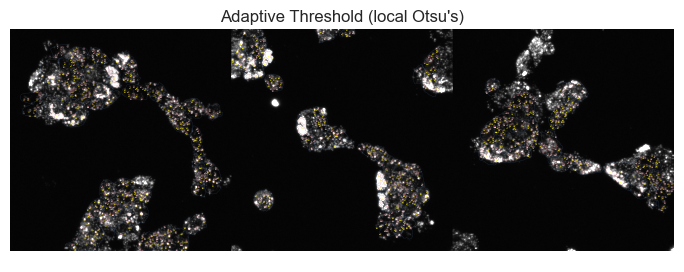

In [ ]:
img_signal = img1_ch3
fname_save = prefix1 + "Malat1_segmentation.png"
cell_polygons = cell_polygons_condition1  # Cell boundaries to use for puncta detection
output_variable_name = (
    "Malat1_puncta_condition1"  # Customize this for your naming convention
)

sigma = 1
mode = "reflect"
area_threshold = 20  # Minimum area in pixels to keep objects

# Apply adaptive thresholding to detect puncta within each cell
all_puncta_polygons, cell_statistics = adaptive_threshold_within_cells_otsu(
    img_signal,
    cell_polygons,
    area_threshold=area_threshold,
    sigma=sigma,
)

# Apply Gaussian smoothing for visualization
img_smoothed = gaussian_filter(img_signal, sigma=sigma, mode=mode)

# Create final visualization with better contrast
plt.figure(figsize=(7, 3))

# Adaptive thresholding result with enhanced contrast
vmin, vmax = np.percentile(
    img_signal, [1, 99]
)  # Use 1st and 99th percentiles for better contrast
plt.imshow(img_signal, cmap="gray", vmin=vmin, vmax=vmax)
plt.title(f"Adaptive Threshold (local Otsu's)")

# Plot cell boundaries in blue
for idx, cell_polygon in enumerate(cell_polygons):
    x, y = cell_polygon.exterior.xy
    plt.plot(x, y, "b-", linewidth=0.1, alpha=0.8)

# Plot puncta boundaries in red with puncta ID labels
puncta_id = 0
for cell_idx, cell_polygon in enumerate(cell_polygons):
    # Find puncta within this cell
    puncta_in_cell = [
        p for p in all_puncta_polygons if cell_polygon.contains(p.centroid)
    ]

    for puncta_polygon in puncta_in_cell:
        # Plot puncta boundary
        x, y = puncta_polygon.exterior.xy
        plt.plot(x, y, "r-", linewidth=0.1)

        # Add puncta ID label
        centroid = puncta_polygon.centroid
        plt.text(
            centroid.x,
            centroid.y,
            str(puncta_id),
            color="yellow",
            fontsize=1,
            ha="center",
            va="center",
        )
        puncta_id += 1

plt.axis("off")
plt.tight_layout()
plt.savefig(
    fname_save,
    format="png",
    dpi=1200,
    bbox_inches=0,
)

# Store results in the specified variable name
globals()[output_variable_name] = all_puncta_polygons

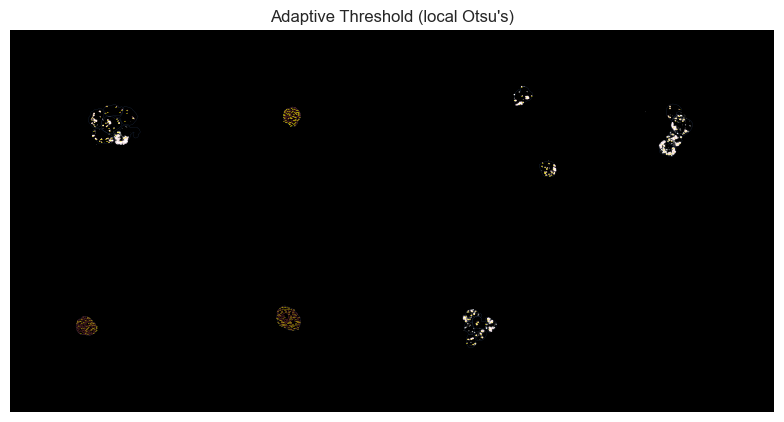

In [22]:
img_signal = img2_ch3
fname_save = prefix2 + "Malat1_segmentation.png"
cell_polygons = cell_polygons_condition2  # Cell boundaries to use for puncta detection
output_variable_name = (
    "Malat1_puncta_condition2"  # Customize this for your naming convention
)

sigma = 1
mode = "reflect"
area_threshold = 5  # Minimum area in pixels to keep objects

# Apply adaptive thresholding to detect puncta within each cell
all_puncta_polygons, cell_statistics = adaptive_threshold_within_cells_otsu(
    img_signal,
    cell_polygons,
    area_threshold=area_threshold,
    sigma=sigma,
)

# Apply Gaussian smoothing for visualization
img_smoothed = gaussian_filter(img_signal, sigma=sigma, mode=mode)

# Create final visualization with better contrast
plt.figure(figsize=(8, 5))

# Adaptive thresholding result with enhanced contrast
vmin, vmax = np.percentile(
    img_signal, [90, 99.9]
)  # Use 1st and 99th percentiles for better contrast
plt.imshow(img_signal, cmap="gray", vmin=vmin, vmax=vmax)
plt.title(f"Adaptive Threshold (local Otsu's)")

# Plot cell boundaries in blue
for idx, cell_polygon in enumerate(cell_polygons):
    x, y = cell_polygon.exterior.xy
    plt.plot(x, y, "b-", linewidth=0.1, alpha=0.8)

# Plot puncta boundaries in red with puncta ID labels
puncta_id = 0
for cell_idx, cell_polygon in enumerate(cell_polygons):
    # Find puncta within this cell
    puncta_in_cell = [
        p for p in all_puncta_polygons if cell_polygon.contains(p.centroid)
    ]

    for puncta_polygon in puncta_in_cell:
        # Plot puncta boundary
        x, y = puncta_polygon.exterior.xy
        plt.plot(x, y, "r-", linewidth=0.1)

        # Add puncta ID label
        centroid = puncta_polygon.centroid
        plt.text(
            centroid.x,
            centroid.y,
            str(puncta_id),
            color="yellow",
            fontsize=1,
            ha="center",
            va="center",
        )
        puncta_id += 1

plt.axis("off")
plt.tight_layout()
plt.savefig(
    fname_save,
    format="png",
    dpi=1200,
    bbox_inches=0,
)

# Store results in the specified variable name
globals()[output_variable_name] = all_puncta_polygons

## Puncta stats

In [23]:
def analyze_puncta_stats(img_signal, cell_polygons, puncta_polygons, nm_per_pxl, label):
    """
    Analyze puncta statistics within cells.

    Args:
        img_signal: 2D numpy array (grayscale image)
        cell_polygons: list of shapely Polygon objects (cell boundaries)
        puncta_polygons: list of shapely Polygon objects (puncta)
        nm_per_pxl: nanometers per pixel conversion factor
        label: string identifier for the condition

    Returns:
        pandas DataFrame with puncta statistics
    """

    # Initialize lists to store metrics
    labels = []
    puncta_ids = []
    cell_ids = []
    puncta_areas = []
    puncta_diameters = []
    puncta_mean_intensities = []
    puncta_circularities = []

    # Get image dimensions
    height, width = img_signal.shape[:2]

    # Conversion factor from pixels^2 to um^2
    area_conversion = (nm_per_pxl / 1e3) ** 2  # nm to um conversion

    for puncta_id, puncta_polygon in enumerate(puncta_polygons):
        try:
            # Find which cell this puncta belongs to
            cell_id = -1  # Default: not in any cell
            for i, cell_polygon in enumerate(cell_polygons):
                if cell_polygon.contains(puncta_polygon.centroid):
                    cell_id = i
                    break

            # Basic info
            labels.append(label)
            puncta_ids.append(puncta_id)
            cell_ids.append(cell_id)

            # Calculate area and diameter
            area_pixels = puncta_polygon.area
            area_um2 = area_pixels * area_conversion
            diameter_um = 2 * np.sqrt(area_um2 / np.pi)  # Equivalent circle diameter

            puncta_areas.append(area_um2)
            puncta_diameters.append(diameter_um)

            # Calculate mean intensity
            mask = polygon_to_mask(puncta_polygon, width, height)
            masked_pixels = img_signal[mask]

            if len(masked_pixels) > 0:
                mean_intensity = np.mean(masked_pixels)
            else:
                mean_intensity = np.nan

            puncta_mean_intensities.append(mean_intensity)

            # Calculate circularity (4π × area / perimeter²)
            perimeter = puncta_polygon.length
            if perimeter > 0:
                circularity = 4 * np.pi * area_pixels / (perimeter**2)
            else:
                circularity = np.nan

            puncta_circularities.append(circularity)

        except Exception as e:
            print(f"Error processing puncta {puncta_id}: {e}")
            # Add NaN/default values for failed puncta
            labels.append(label)
            puncta_ids.append(puncta_id)
            cell_ids.append(-1)
            puncta_areas.append(np.nan)
            puncta_diameters.append(np.nan)
            puncta_mean_intensities.append(np.nan)
            puncta_circularities.append(np.nan)

    # Create DataFrame
    df = pd.DataFrame(
        {
            "Label": labels,
            "Puncta_ID": puncta_ids,
            "Cell_ID": cell_ids,
            "Puncta_Area_um2": puncta_areas,
            "Puncta_Diameter_um": puncta_diameters,
            "Puncta_Mean_Intensity": puncta_mean_intensities,
            "Puncta_Circularity": puncta_circularities,
        }
    )

    return df

In [25]:
df_SC35_WT = analyze_puncta_stats(
    img1_ch2,
    cell_polygons_condition1,
    SC35_puncta_condition1,
    nm_per_pxl,
    "control ASO",
)
df_SC35_KD = analyze_puncta_stats(
    img2_ch2,
    cell_polygons_condition2,
    SC35_puncta_condition2,
    nm_per_pxl,
    "Malat1 KD",
)
df_Malat1_WT = analyze_puncta_stats(
    img1_ch3,
    cell_polygons_condition1,
    Malat1_puncta_condition1,
    nm_per_pxl,
    "control ASO",
)
df_Malat1_KD = analyze_puncta_stats(
    img2_ch3,
    cell_polygons_condition2,
    Malat1_puncta_condition2,
    nm_per_pxl,
    "Malat1 KD",
)
df_SC35_puncta_stats = pd.concat([df_SC35_WT, df_SC35_KD])
df_SC35_puncta_stats.to_csv("Malat1_WT_vs_KD-puncta_stats-SC35.csv", index=False)
df_Malat1_puncta_stats = pd.concat([df_Malat1_WT, df_Malat1_KD])
df_Malat1_puncta_stats.to_csv("Malat1_WT_vs_KD-puncta_stats-Malat1.csv", index=False)

# Plot Stats

## Plot per cell stats

In [26]:
def plot_condition_comparison_subplots(
    df,
    title,
    statistical_test="t-test_ind",
    text_format="star",
    figsize=(15, 10),
    save_path=None,
    swarm_alpha=0.7,
    fontsize=14,
):
    """
    Create 3x2 subplots comparing conditions for columns 3-8 of the dataframe.

    Args:
        df: pandas DataFrame with 'Label' column containing conditions
        title: string, main title for all subplots
        statistical_test: string, type of statistical test ('t-test_ind', 'Mann-Whitney', etc.)
        text_format: string, format for p-value display ('star', 'simple', 'full')
        figsize: tuple, figure size (width, height)
        save_path: string, path to save the plot (optional)
        swarm_alpha: float, transparency of swarm plot points
        fontsize: int, font size for labels and ticks
    """

    # Get unique conditions and sort them
    conditions = sorted(df["Label"].unique(), reverse=True)

    if len(conditions) != 2:
        raise ValueError(
            f"Expected 2 conditions, but found {len(conditions)}: {conditions}"
        )

    # Get columns 3-8 (indices 2-7)
    columns_to_plot = df.columns[2:8].tolist()

    if len(columns_to_plot) != 6:
        raise ValueError(
            f"Expected 6 columns (3rd-8th), but found {len(columns_to_plot)}"
        )

    # Set up color palette for conditions
    colors = sns.color_palette("Set2", len(conditions))
    condition_colors = dict(zip(conditions, colors))

    # Create subplots
    fig, axes = plt.subplots(2, 3, figsize=figsize)
    axes = axes.flatten()

    # Plot each column in a separate subplot
    for i, column in enumerate(columns_to_plot):
        ax = axes[i]

        # Create boxplot with different colors for each condition
        sns.boxplot(
            data=df,
            x="Label",
            y=column,
            hue="Label",
            order=conditions,
            palette=condition_colors,
            width=0.6,
            ax=ax,
        )

        # Overlay swarm plot
        sns.swarmplot(
            x="Label",
            y=column,
            data=df,
            color="black",
            alpha=swarm_alpha,
            order=conditions,
            ax=ax,
        )

        # Define comparison pair
        pairs = [(conditions[0], conditions[1])]

        # Add statistical annotations
        annotator = Annotator(
            ax,
            pairs,
            data=df,
            x="Label",
            y=column,
            order=conditions,
        )
        annotator.configure(
            test=statistical_test, text_format=text_format, loc="inside"
        )
        annotator.apply_and_annotate()

        # Style adjustments - replace underscores with spaces in y-label
        ax.set_xlabel("")
        ax.set_ylabel(column.replace("_", " "), fontsize=fontsize)
        ax.set_xticks([])  # Remove x ticks

        # Spine and tick styling
        for spine in ax.spines.values():
            spine.set_linewidth(1)
        ax.tick_params(
            axis="both",
            which="major",
            labelsize=fontsize,
            direction="in",
            bottom=False,  # No bottom ticks since we removed x ticks
            left=True,
            length=5,
            width=1,
        )

    # Add main title - positioned lower
    fig.suptitle(title, fontsize=fontsize + 5, fontweight="bold", y=0.92)

    # Create legend at the top
    handles = [
        plt.Rectangle((0, 0), 1, 1, color=condition_colors[condition])
        for condition in conditions
    ]
    fig.legend(
        handles,
        conditions,
        loc="upper center",
        bbox_to_anchor=(0.5, 0.90),
        ncol=len(conditions),
        fontsize=fontsize,
        frameon=False,
    )

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)  # Make room for title and legend

    if save_path:
        plt.savefig(save_path, format="png", dpi=300, bbox_inches="tight")

    return fig, axes

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

control ASO vs. Malat1 KD: Mann-Whitney-Wilcoxon test two-sided, P_val:2.602e-01 U_stat=9.120e+02
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

control ASO vs. Malat1 KD: Mann-Whitney-Wilcoxon test two-sided, P_val:1.217e-03 U_stat=1.568e+03


/opt/miniconda3/envs/spt/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 59.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/miniconda3/envs/spt/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 28.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/miniconda3/envs/spt/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 63.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/miniconda3/envs/spt/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 38.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

control ASO vs. Malat1 KD: Mann-Whitney-Wilcoxon test two-sided, P_val:5.943e-13 U_stat=2.163e+03


/opt/miniconda3/envs/spt/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 63.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/miniconda3/envs/spt/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 38.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/miniconda3/envs/spt/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 63.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/miniconda3/envs/spt/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 38.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

control ASO vs. Malat1 KD: Mann-Whitney-Wilcoxon test two-sided, P_val:5.948e-13 U_stat=2.163e+03


/opt/miniconda3/envs/spt/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 63.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/miniconda3/envs/spt/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 38.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/miniconda3/envs/spt/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 63.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/miniconda3/envs/spt/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 38.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

control ASO vs. Malat1 KD: Mann-Whitney-Wilcoxon test two-sided, P_val:8.276e-11 U_stat=2.057e+03


/opt/miniconda3/envs/spt/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 63.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/miniconda3/envs/spt/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 38.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/miniconda3/envs/spt/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 63.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/miniconda3/envs/spt/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 38.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

control ASO vs. Malat1 KD: Mann-Whitney-Wilcoxon test two-sided, P_val:3.579e-01 U_stat=9.430e+02
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

control ASO vs. Malat1 KD: Mann-Whitney-Wilcoxon test two-sided, P_val:2.602e-01 U_stat=9.120e+02
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

control ASO vs. Malat1 KD: Mann-Whitney-Wilcoxon test two-sided, P_val:4.457e-12 U_stat=2.121e+03


/opt/miniconda3/envs/spt/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 72.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/miniconda3/envs/spt/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 28.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/miniconda3/envs/spt/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 76.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/miniconda3/envs/spt/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 38.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

control ASO vs. Malat1 KD: Mann-Whitney-Wilcoxon test two-sided, P_val:5.945e-13 U_stat=2.163e+03


/opt/miniconda3/envs/spt/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 76.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/miniconda3/envs/spt/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 38.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/miniconda3/envs/spt/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 14.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/miniconda3/envs/spt/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 76.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/miniconda3/envs/spt/lib/python3.9/site-packages/seaborn/cat

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

control ASO vs. Malat1 KD: Mann-Whitney-Wilcoxon test two-sided, P_val:6.886e-13 U_stat=2.160e+03


/opt/miniconda3/envs/spt/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 76.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/miniconda3/envs/spt/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 38.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/miniconda3/envs/spt/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 20.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/miniconda3/envs/spt/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 9.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/miniconda3/envs/spt/lib/python3.9/site-packages/seaborn/cate

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

control ASO vs. Malat1 KD: Mann-Whitney-Wilcoxon test two-sided, P_val:1.991e-12 U_stat=2.138e+03


/opt/miniconda3/envs/spt/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 76.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/miniconda3/envs/spt/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 38.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/miniconda3/envs/spt/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 20.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/miniconda3/envs/spt/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 9.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/miniconda3/envs/spt/lib/python3.9/site-packages/seaborn/cate

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

control ASO vs. Malat1 KD: Mann-Whitney-Wilcoxon test two-sided, P_val:4.476e-01 U_stat=1.196e+03


/opt/miniconda3/envs/spt/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 73.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/miniconda3/envs/spt/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 15.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/miniconda3/envs/spt/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 9.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

control ASO vs. Malat1 KD: Mann-Whitney-Wilcoxon test two-sided, P_val:2.602e-01 U_stat=9.120e+02
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

control ASO vs. Malat1 KD: Mann-Whitney-Wilcoxon test two-sided, P_val:1.012e-01 U_stat=1.328e+03


/opt/miniconda3/envs/spt/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 70.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/miniconda3/envs/spt/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 72.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/miniconda3/envs/spt/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 9.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

control ASO vs. Malat1 KD: Mann-Whitney-Wilcoxon test two-sided, P_val:1.447e-02 U_stat=7.140e+02


/opt/miniconda3/envs/spt/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 72.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/miniconda3/envs/spt/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 9.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/miniconda3/envs/spt/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 72.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/miniconda3/envs/spt/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 9.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

control ASO vs. Malat1 KD: Mann-Whitney-Wilcoxon test two-sided, P_val:2.491e-01 U_stat=9.080e+02


/opt/miniconda3/envs/spt/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 72.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/miniconda3/envs/spt/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 9.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/miniconda3/envs/spt/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 72.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/miniconda3/envs/spt/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 9.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

control ASO vs. Malat1 KD: Mann-Whitney-Wilcoxon test two-sided, P_val:5.948e-13 U_stat=2.163e+03


/opt/miniconda3/envs/spt/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 72.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/miniconda3/envs/spt/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 9.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/miniconda3/envs/spt/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 14.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/miniconda3/envs/spt/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 72.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/miniconda3/envs/spt/lib/python3.9/site-packages/seaborn/cate

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

control ASO vs. Malat1 KD: Mann-Whitney-Wilcoxon test two-sided, P_val:6.886e-13 U_stat=2.160e+03


/opt/miniconda3/envs/spt/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 15.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/miniconda3/envs/spt/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 63.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/miniconda3/envs/spt/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 38.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


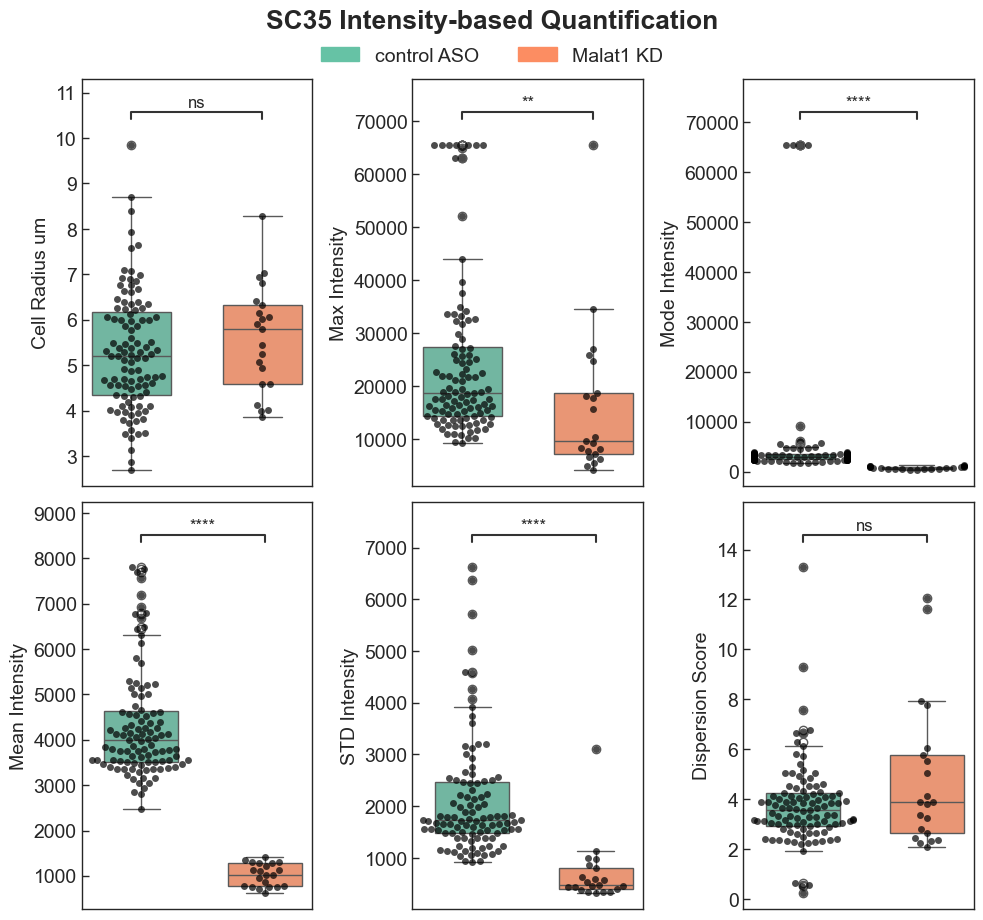

/opt/miniconda3/envs/spt/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 73.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/miniconda3/envs/spt/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 9.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


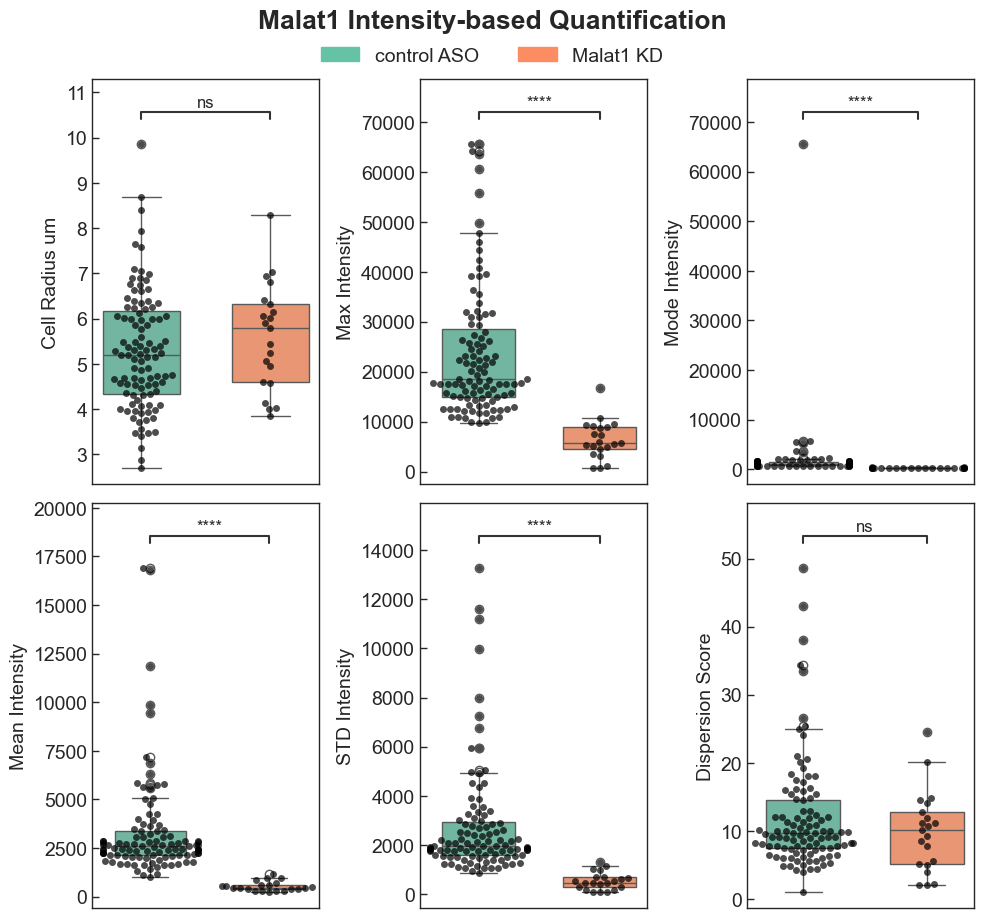

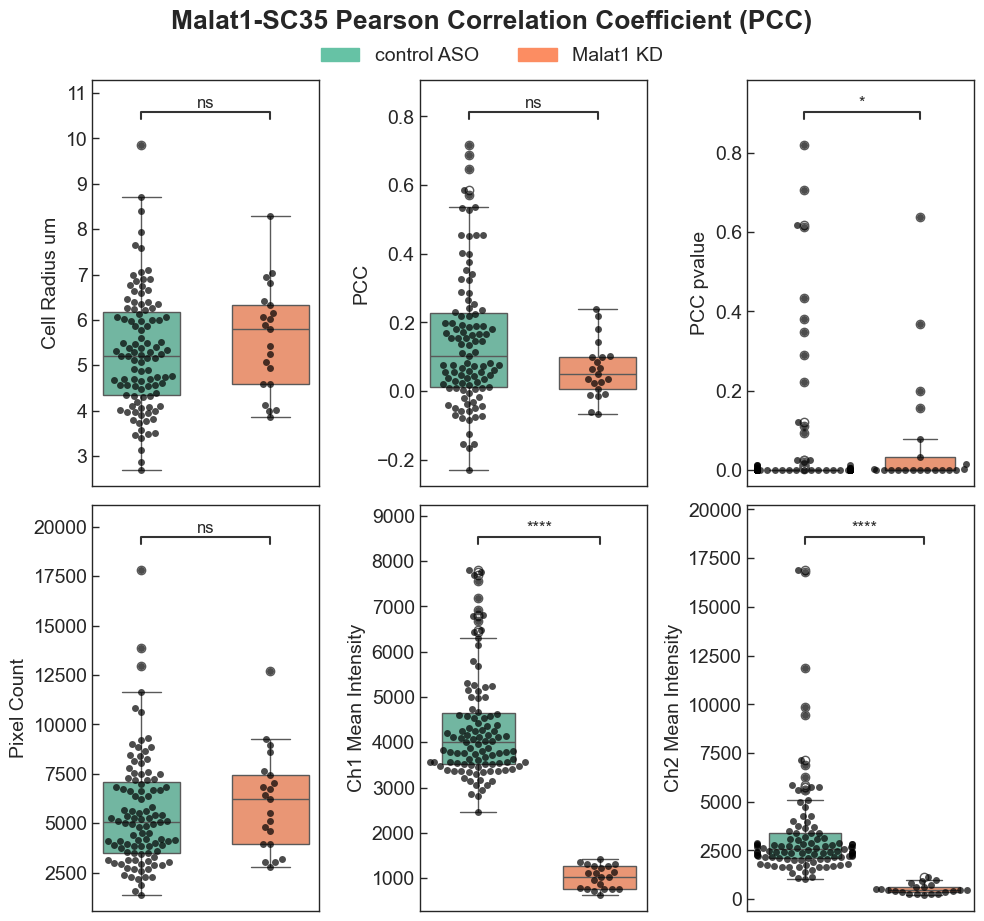

In [31]:
fig, axes = plot_condition_comparison_subplots(
    df=df_SC35_perCell_stats,
    statistical_test="Mann-Whitney",
    text_format="star",
    figsize=(10, 10),
    save_path="perCell_stats-Malat1_WT_vs_KD-SC35.png",
    title="SC35 Intensity-based Quantification",
)

fig, axes = plot_condition_comparison_subplots(
    df=df_Malat1_perCell_stats,
    statistical_test="Mann-Whitney",
    text_format="star",
    figsize=(10, 10),
    save_path="perCell_stats-Malat1_WT_vs_KD-Malat1.png",
    title="Malat1 Intensity-based Quantification",
)

fig, axes = plot_condition_comparison_subplots(
    df=df_PCC_perCell_stats,
    statistical_test="Mann-Whitney",
    text_format="star",
    figsize=(10, 10),
    save_path="perCell_stats-Malat1_WT_vs_KD-PCC.png",
    title="Malat1-SC35 Pearson Correlation Coefficient (PCC)",
)

## Plot puncta stats

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

control ASO vs. Malat1 KD: Mann-Whitney-Wilcoxon test two-sided, P_val:7.950e-09 U_stat=2.543e+05
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

control ASO vs. Malat1 KD: Mann-Whitney-Wilcoxon test two-sided, P_val:7.950e-09 U_stat=2.543e+05
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

control ASO vs. Malat1 KD: Mann-Whitney-Wilcoxon test two-sided, P_val:2.016e-175 U_stat=4.206e+05
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-

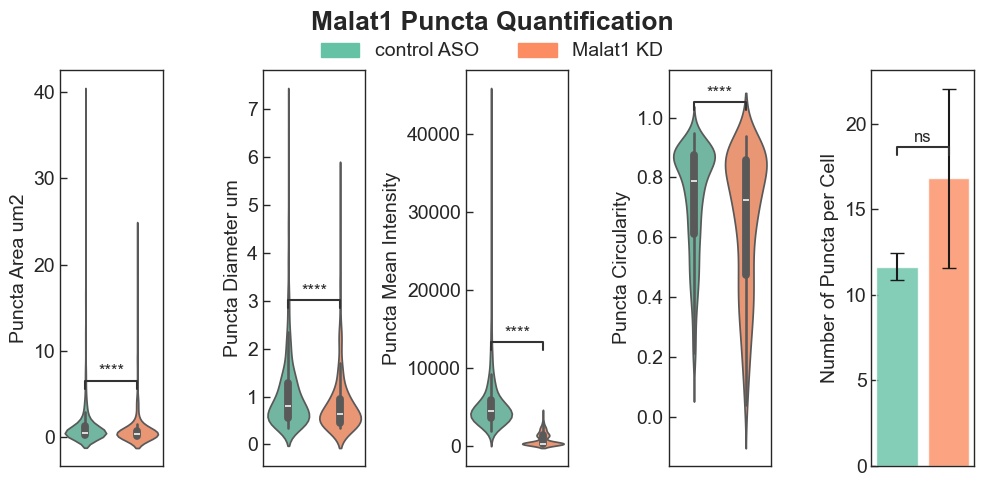

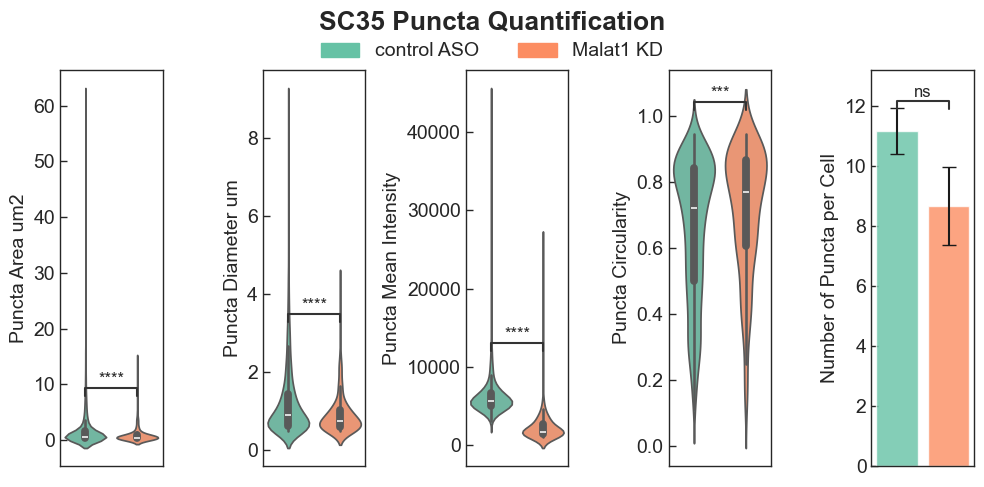

In [33]:
def plot_condition_comparison_subplots_v2(
    df,
    title,
    statistical_test="t-test_ind",
    text_format="star",
    figsize=(25, 5),
    save_path=None,
    fontsize=14,
):
    """
    Create 1x5 subplots comparing conditions for columns 4-7 of the dataframe,
    plus a barplot of number of puncta per cell.

    Args:
        df: pandas DataFrame with 'Label' column containing conditions
        title: string, main title for all subplots
        statistical_test: string, type of statistical test ('t-test_ind', 'Mann-Whitney', etc.)
        text_format: string, format for p-value display ('star', 'simple', 'full')
        figsize: tuple, figure size (width, height)
        save_path: string, path to save the plot (optional)
        fontsize: int, font size for labels and ticks
    """

    # Filter out Cell_ID == -1 (puncta not inside any cell)
    df_filtered = df[df["Cell_ID"] != -1]

    # Get unique conditions and sort them
    conditions = sorted(df_filtered["Label"].unique(), reverse=True)

    if len(conditions) != 2:
        raise ValueError(
            f"Expected 2 conditions, but found {len(conditions)}: {conditions}"
        )

    # Get columns 4-7 (indices 3-6) - fourth to seventh columns
    columns_to_plot = df_filtered.columns[3:7].tolist()

    if len(columns_to_plot) != 4:
        raise ValueError(
            f"Expected 4 columns (4th-7th), but found {len(columns_to_plot)}"
        )

    # Set up color palette for conditions
    colors = sns.color_palette("Set2", len(conditions))
    condition_colors = dict(zip(conditions, colors))

    # Create subplots - 1 row, 5 columns
    fig, axes = plt.subplots(1, 5, figsize=figsize)

    # Plot each column in a separate subplot (first 4 plots)
    for i, column in enumerate(columns_to_plot):
        ax = axes[i]

        # Create violin plot with box plot elements inside
        sns.violinplot(
            data=df_filtered,
            x="Label",
            y=column,
            hue="Label",
            order=conditions,
            palette=condition_colors,
            inner="box",  # Shows box plot elements inside violin
            ax=ax,
        )

        # Define comparison pair
        pairs = [(conditions[0], conditions[1])]

        # Add statistical annotations
        annotator = Annotator(
            ax,
            pairs,
            data=df_filtered,
            x="Label",
            y=column,
            order=conditions,
        )
        annotator.configure(
            test=statistical_test, text_format=text_format, loc="inside"
        )
        annotator.apply_and_annotate()

        # Style adjustments - replace underscores with spaces in y-label
        ax.set_xlabel("")
        ax.set_ylabel(column.replace("_", " "), fontsize=fontsize)
        ax.set_xticks([])  # Remove x ticks

        # Spine and tick styling
        for spine in ax.spines.values():
            spine.set_linewidth(1)
        ax.tick_params(
            axis="both",
            which="major",
            labelsize=fontsize,
            direction="in",
            bottom=False,  # No bottom ticks since we removed x ticks
            left=True,
            length=5,
            width=1,
        )

    # Fifth plot: barplot with error bars of number of puncta per cell
    ax = axes[4]

    # Calculate number of puncta per cell for each condition
    puncta_per_cell = (
        df_filtered.groupby(["Label", "Cell_ID"])
        .size()
        .reset_index(name="Puncta_Count")
    )

    # Calculate mean and standard error for each condition
    # FIXED: Maintain the same order as conditions variable
    summary_stats = (
        puncta_per_cell.groupby("Label")
        .agg(mean_puncta=("Puncta_Count", "mean"), sem_puncta=("Puncta_Count", "sem"))
        .reset_index()
    )

    # Reorder summary_stats to match conditions order
    summary_stats = summary_stats.set_index("Label").reindex(conditions).reset_index()

    # Use matplotlib's bar plot with built-in error bars (properly aligned)
    x_pos = range(len(summary_stats))
    bars = ax.bar(
        x_pos,
        summary_stats["mean_puncta"],
        yerr=summary_stats["sem_puncta"],
        capsize=5,
        color=[
            condition_colors[label] for label in conditions
        ],  # Use conditions order directly
        alpha=0.8,
    )

    # Set x-axis labels using conditions order
    ax.set_xticks(x_pos)
    ax.set_xticklabels(conditions, rotation=0)

    # Add statistical comparison for the barplot
    pairs = [(conditions[0], conditions[1])]
    annotator = Annotator(
        ax,
        pairs,
        data=puncta_per_cell,
        x="Label",
        y="Puncta_Count",
        order=conditions,
    )
    annotator.configure(test=statistical_test, text_format=text_format, loc="inside")
    annotator.apply_and_annotate()

    # Style the barplot
    ax.set_ylabel("Number of Puncta per Cell", fontsize=fontsize)
    ax.set_xlabel("")
    ax.set_xticks([])  # Remove x ticks to match other plots

    for spine in ax.spines.values():
        spine.set_linewidth(1)
    ax.tick_params(
        axis="both",
        which="major",
        labelsize=fontsize,
        direction="in",
        bottom=False,
        left=True,
        length=5,
        width=1,
    )

    # Add main title - positioned lower
    fig.suptitle(title, fontsize=fontsize + 5, fontweight="bold", y=0.97)

    # Create legend at the top
    handles = [
        plt.Rectangle((0, 0), 1, 1, color=condition_colors[condition])
        for condition in conditions
    ]
    fig.legend(
        handles,
        conditions,
        loc="upper center",
        bbox_to_anchor=(0.5, 0.94),
        ncol=len(conditions),
        fontsize=fontsize,
        frameon=False,
    )

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)  # Make room for title and legend

    if save_path:
        plt.savefig(save_path, format="png", dpi=300, bbox_inches="tight")

    return fig, axes


fig, axes = plot_condition_comparison_subplots_v2(
    df=df_Malat1_puncta_stats,
    statistical_test="Mann-Whitney",
    text_format="star",
    figsize=(10, 5),
    save_path="puncta_stats-Malat1_WT_vs_KD-Malat1.png",
    title="Malat1 Puncta Quantification",
)
fig, axes = plot_condition_comparison_subplots_v2(
    df=df_SC35_puncta_stats,
    statistical_test="Mann-Whitney",
    text_format="star",
    figsize=(10, 5),
    save_path="puncta_stats-Malat1_WT_vs_KD-SC35.png",
    title="SC35 Puncta Quantification",
)